## Dog vs Cat Image Classification

### !!! Start from [Check Point 1](#Check Point 1) if data have beeen preprocessed and saved to disk when coming back to this notebook.

In [ ]:
%matplotlib inline
import cv2, os, pickle
import numpy as np
import tensorflow as tf
from tensorflow_vgg import vgg16
from tensorflow_vgg import utils
import csv

from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.model_selection import train_test_split

print('All modules are imported.')

## 1. Preparing the Data

### 1.1 Explore the Data
#### Dataset statistics

In [ ]:
# Image directoires
TRAIN_DIR = 'input/train/'
TEST_DIR = 'input/test/'

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]
test_images = [TEST_DIR+i for i in os.listdir(TEST_DIR)]

# print out statistics of the dataset and show example images
print("Stats of Dog_vs_Cat Train Dataset")
print("Total Images: {}".format(len(train_images)))
print("Dog:          {}".format(len([i for i in train_images if 'dog' in i ])))
print("Cat:          {}".format(len([i for i in train_images if 'cat' in i ])))
print('')
print('Stats of Dog_vs_Cat Test Dataset')
print('Total Images: {}'.format(len(test_images)))

#### Display Example Images

In [ ]:
# Explore the dataset
image_id_list = ['cat.2341', 'cat.1623', 'dog.6128']

for image_id in image_id_list:
    image_example = cv2.imread('input/train/{}.jpg'.format(image_id), cv2.IMREAD_COLOR)
    print("Example of Train Image: {}.jpg".format(image_id))
    print("Image - Shape: {}".format(image_example.shape))
    print("Image - Min Value: {}, Max Value: {}".format(image_example.min(), image_example.max()))
    print("Label - {}".format('dog' if 'dog' in 'input/train/{}.jpg'.format(image_id) else 'cat'))
    display(Image.open('input/train/{}.jpg'.format(image_id)))

In [ ]:
# Set the batch size higher if you can fit in in your GPU memory
batch_size = 50
labels = []

classes = ['cat', 'dog']

#test dataset preprocessing
test_id_list = []
batch = []

codes = None
test_codes =  None

with tf.Session() as sess:
    
    vgg = vgg16.Vgg16()
    input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
    with tf.name_scope('content_vgg'):
        vgg.build(input_)
        
    for each in classes:        
        print("Start preprocessing {} images".format(each))
        files = [i for i in train_images if each in i]
        for ii, file in tqdm(enumerate(files, 1), desc='{} images'.format(each), unit='Images'):
            # Add images to the current batch
            # utils.load_image crops the input images for us, from the center
            img = utils.load_image(file)
            batch.append(img.reshape((1, 224, 224, 3)))
            labels.append(each)
            
            # Running the batch through the network to get the codes
            if ii % batch_size == 0 or ii == len(files):
                
                # Image batch to pass to VGG network
                images = np.concatenate(batch)
                codes_batch = sess.run(vgg.relu6, feed_dict = {input_ : images})
                
                # Here I'm building an array of the codes
                if codes is None:
                    codes = codes_batch
                else:
                    codes = np.concatenate((codes, codes_batch))
                
                # Reset to start building the next batch
                batch = []
    
    batch = []
    #Process test images  
    print("Start preprocessing test images")
    for ii, file in tqdm(enumerate(test_images, 1), desc='test images', unit='Images'):
        # Add images to the current batch
        # utils.load_image crops the input images for us, from the center
        img = utils.load_image(file)
        batch.append(img.reshape((1, 224, 224, 3)))
        test_id_list.append(int(file.split('/')[2].split('.')[0]))
            
        # Running the batch through the network to get the codes
        if ii % batch_size == 0 or ii == len(files):
                
            # Image batch to pass to VGG network
            images = np.concatenate(batch)                
            codes_batch = sess.run(vgg.relu6, feed_dict = {input_ : images})
                
            # Here I'm building an array of the codes
            if test_codes is None:
                test_codes = codes_batch
            else:
                test_codes = np.concatenate((test_codes, codes_batch))
                
            # Reset to start building the next batch
            batch = []

In [4]:
if not os.path.isfile('codes'):
    print('Saving train codes to file...')
    # write codes to file
    try:
        with open('codes', 'w') as f:
            codes.tofile(f)
    except Exception as e:
        print('Unable to save data to: codes')

print('Train codes are cached in file: codes')

if not os.path.isfile('labels'):
    print('Saving train labels to file...')
    # write labels to file
    try:
        with open('labels', 'w') as f:
            writer = csv.writer(f, delimiter='\n')
            writer.writerow(labels)
    except Exception as e:
        print('Unable to save data to: labels')

print('Train Labels are cached in file: labels')

if not os.path.isfile('test_codes'):
    print('Saving test codes to file...')
    try:
        # write test codes to file
        with open('test_codes', 'w') as f:
            test_codes.tofile(f)
    except Exception as e:
        print('Unable to save data to: test_codes')
print('Test codes are cached in file: test_codes')

if not os.path.isfile('test_ids'):
    print('Saving test ids to file...')
    # write test ids to file
    try:
        with open('test_ids', 'w') as f:
            writer = csv.writer(f, delimiter='\n')
            writer.writerow(test_id_list)
    except Exception as e:
        print('Unable to save data to: test_ids')
print('Test ids are cached in file: test_ids')

Train codes are cached in file: codes
Train Labels are cached in file: labels
Test codes are cached in file: test_codes
Test ids are cached in file: test_ids


<a id='Check Point 1'></a>
## Check Point 1

If come back to this notebook or have to restart the notebook, start from here. The preprocessed data have been saved to disk.

In [1]:
%matplotlib inline
import cv2, os, pickle, csv
import numpy as np
import tensorflow as tf
from tensorflow_vgg import vgg16
from tensorflow_vgg import utils

from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.model_selection import train_test_split

print('All modules are imported.')

All modules are imported.


In [3]:
try:
    with open('labels') as f:
        reader = csv.reader(f, delimiter='\n')
        labels = np.array([each for each in reader if len(each) > 0]).squeeze()
    print('Train codes are reloaded from local disk.')
    print("Train codes shape:", codes.shape)
except Exception as e:
    print('Unable to reload train codes')
    

try:   
    with open('codes') as f:
        codes = np.fromfile(f, dtype=np.float32)
        codes = codes.reshape((len(labels), -1))
    print('Train labels are reloaded from local disk')
    print("Train labels shape:", labels.shape)

except Exception as e:
    print('Unable to reload train labels')

Train codes are reloaded from local disk.
Train codes shape: (25000, 4096)
Train labels are reloaded from local disk
Train labels shape: (25000,)


### One-hot encode

In [4]:
labels_vecs = [[0, 1] if 'cat' in i else [1, 0] for i in labels]
labels_vecs = np.array(labels_vecs)
print('Train Labels are one-hot coded')
print('Cat: [0, 1]')
print('Dog: [1, 0]')
print('Label shape:', labels_vecs.shape)

Train Labels are one-hot coded
Cat: [0, 1]
Dog: [1, 0]
Label shape: (25000, 2)


### Train test split

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

ss = StratifiedShuffleSplit(n_splits=1, test_size=0.04, random_state=42)
train_idx, val_idx = next(ss.split(codes, labels_vecs))
train_x, train_y = codes[train_idx], labels_vecs[train_idx]
val_x, val_y = codes[val_idx], labels_vecs[val_idx]

In [7]:
print("Train shapes (x, y):", train_x.shape, train_y.shape)
print("Validation shapes (x, y):", val_x.shape, val_y.shape)

Train shapes (x, y): (24000, 4096) (24000, 2)
Validation shapes (x, y): (1000, 4096) (1000, 2)


In [31]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    weight = tf.Variable(tf.truncated_normal((x_tensor.shape[-1].value, num_outputs),
                                            stddev = 0.01))
    bias = tf.Variable(tf.zeros([num_outputs]))
    fc_x = tf.add(tf.matmul(x_tensor, weight), bias)
    fc_x = tf.nn.relu(fc_x)
    
    return fc_x

In [32]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    weight = tf.Variable(tf.truncated_normal([x_tensor.shape[-1].value,num_outputs],
                                            stddev=0.01))
    bias = tf.Variable(tf.zeros([num_outputs]))
    return tf.add(tf.matmul(x_tensor, weight), bias)

In [90]:
##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
inputs_ = tf.placeholder(tf.float32, shape=[None, codes.shape[1]], name='inputs')
labels_ = tf.placeholder(tf.int64, shape=[None, labels_vecs.shape[1]], name='y')
#is_training = tf.placeholder(tf.bool, name='is_training')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

num_input = inputs_.shape[-1].value
num_output = labels_.shape[-1].value

# Model
#batch_normalized_output = tf.layers.batch_normalization(inputs_, training=is_training)
fc = fully_conn(inputs_, 4)
fc = tf.nn.dropout(fc, keep_prob=keep_prob)
logits = output(fc, 2)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizaer
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=labels_, logits=logits)
cost = tf.reduce_mean(cross_entropy, name='cost')

# Tell TensorFlow to update the population statisitcs while training
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [91]:
def get_batches(x, y, n_batches=10):
    """ Return a generator that yields batches from arrays x and y. """
    batch_size = len(x)//n_batches
    
    for ii in range(0, n_batches*batch_size, batch_size):
        # If we're not on the last batch, grab data with size batch_size
        if ii != (n_batches-1)*batch_size:
            X, Y = x[ii: ii+batch_size], y[ii: ii+batch_size] 
        # On the last batch, grab the rest of the data
        else:
            X, Y = x[ii:], y[ii:]
        # I love generators
        yield X, Y

#### Hyperparameters

In [92]:
# Tune Parameters
epochs = 20
keep_probability = 0.3

In [93]:
save_model_path = './dog_vs_cat'

iteration = 0
train_loss_iter = []
train_acc_iter = []
val_loss_iter = []
val_acc_iter = []

log_freq = 10
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for e in tqdm(range(epochs), desc='Running Epoch', unit='Epoch'):
        for x, y in get_batches(train_x, train_y):
            loss, acc, _ = sess.run([cost, accuracy, optimizer], feed_dict={inputs_: x,
                                                                            labels_: y,
                                                                            keep_prob: keep_probability})
            
            if iteration % log_freq == 0:
                loss, acc = sess.run([cost, accuracy], feed_dict={inputs_: x,
                                                                  labels_: y,
                                                                  keep_prob: 1.0})
                train_loss_iter.append(loss)
                train_acc_iter.append(acc)
                val_loss, val_acc = sess.run([cost, accuracy], feed_dict={inputs_: val_x,
                                                                          labels_: val_y,
                                                                          keep_prob: 1.0})
                val_loss_iter.append(val_loss)
                val_acc_iter.append(val_acc)
                print("Epoch: {}/{}".format(e+1, epochs),
                      "Iteration: {}".format(iteration),
                      'Train Loss: {:.>3.5f}'.format(train_loss_iter[int(iteration/log_freq)]),
                      'Train Acc: {:.2f}%'.format(train_acc_iter[int(iteration/log_freq)]*100),
                      'Validation Loss: {:.5f}'.format(val_loss_iter[int(iteration/log_freq)]),
                      'Validation Acc: {:.2f}%'.format(val_acc_iter[int(iteration/log_freq)]*100))
            iteration += 1
    
    # Save model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Running Epoch:   0%|                                                                         | 0/20 [00:00<?, ?Epoch/s]

Epoch: 1/20 Iteration: 0 Train Loss: 0.68391 Train Acc: 79.42% Validation Loss: 0.68432 Validation Acc: 77.60%


Running Epoch:   5%|███▎                                                             | 1/20 [00:00<00:04,  3.82Epoch/s]

Epoch: 2/20 Iteration: 10 Train Loss: 0.23275 Train Acc: 98.21% Validation Loss: 0.24108 Validation Acc: 97.60%


Running Epoch:  10%|██████▌                                                          | 2/20 [00:00<00:04,  4.25Epoch/s]

Epoch: 3/20 Iteration: 20 Train Loss: 0.09354 Train Acc: 98.37% Validation Loss: 0.10377 Validation Acc: 97.80%


Running Epoch:  15%|█████████▊                                                       | 3/20 [00:00<00:03,  4.41Epoch/s]

Epoch: 4/20 Iteration: 30 Train Loss: 0.06002 Train Acc: 98.79% Validation Loss: 0.07225 Validation Acc: 98.00%


Running Epoch:  20%|█████████████                                                    | 4/20 [00:00<00:03,  4.46Epoch/s]

Epoch: 5/20 Iteration: 40 Train Loss: 0.04811 Train Acc: 98.83% Validation Loss: 0.06013 Validation Acc: 98.20%


Running Epoch:  25%|████████████████▎                                                | 5/20 [00:01<00:03,  4.50Epoch/s]

Epoch: 6/20 Iteration: 50 Train Loss: 0.04354 Train Acc: 98.83% Validation Loss: 0.05577 Validation Acc: 98.30%


Running Epoch:  30%|███████████████████▌                                             | 6/20 [00:01<00:03,  4.52Epoch/s]

Epoch: 7/20 Iteration: 60 Train Loss: 0.04324 Train Acc: 98.87% Validation Loss: 0.05564 Validation Acc: 98.30%


Running Epoch:  35%|██████████████████████▊                                          | 7/20 [00:01<00:02,  4.53Epoch/s]

Epoch: 8/20 Iteration: 70 Train Loss: 0.03818 Train Acc: 98.87% Validation Loss: 0.05185 Validation Acc: 98.30%


Running Epoch:  40%|██████████████████████████                                       | 8/20 [00:01<00:02,  4.56Epoch/s]

Epoch: 9/20 Iteration: 80 Train Loss: 0.03740 Train Acc: 99.04% Validation Loss: 0.05186 Validation Acc: 98.30%


Running Epoch:  45%|█████████████████████████████▎                                   | 9/20 [00:01<00:02,  4.57Epoch/s]

Epoch: 10/20 Iteration: 90 Train Loss: 0.03579 Train Acc: 99.17% Validation Loss: 0.05096 Validation Acc: 98.40%


Running Epoch:  50%|████████████████████████████████                                | 10/20 [00:02<00:02,  4.59Epoch/s]

Epoch: 11/20 Iteration: 100 Train Loss: 0.03294 Train Acc: 99.12% Validation Loss: 0.04856 Validation Acc: 98.30%


Running Epoch:  55%|███████████████████████████████████▏                            | 11/20 [00:02<00:01,  4.62Epoch/s]

Epoch: 12/20 Iteration: 110 Train Loss: 0.03526 Train Acc: 99.17% Validation Loss: 0.05051 Validation Acc: 98.30%


Running Epoch:  60%|██████████████████████████████████████▍                         | 12/20 [00:02<00:01,  4.62Epoch/s]

Epoch: 13/20 Iteration: 120 Train Loss: 0.03256 Train Acc: 99.25% Validation Loss: 0.04859 Validation Acc: 98.40%


Running Epoch:  65%|█████████████████████████████████████████▌                      | 13/20 [00:02<00:01,  4.62Epoch/s]

Epoch: 14/20 Iteration: 130 Train Loss: 0.03093 Train Acc: 99.37% Validation Loss: 0.04835 Validation Acc: 98.20%


Running Epoch:  70%|████████████████████████████████████████████▊                   | 14/20 [00:03<00:01,  4.64Epoch/s]

Epoch: 15/20 Iteration: 140 Train Loss: 0.02940 Train Acc: 99.37% Validation Loss: 0.04728 Validation Acc: 98.40%


Running Epoch:  75%|████████████████████████████████████████████████                | 15/20 [00:03<00:01,  4.64Epoch/s]

Epoch: 16/20 Iteration: 150 Train Loss: 0.02915 Train Acc: 99.37% Validation Loss: 0.04693 Validation Acc: 98.40%


Running Epoch:  80%|███████████████████████████████████████████████████▏            | 16/20 [00:03<00:00,  4.65Epoch/s]

Epoch: 17/20 Iteration: 160 Train Loss: 0.02969 Train Acc: 99.42% Validation Loss: 0.04698 Validation Acc: 98.40%


Running Epoch:  85%|██████████████████████████████████████████████████████▍         | 17/20 [00:03<00:00,  4.65Epoch/s]

Epoch: 18/20 Iteration: 170 Train Loss: 0.02603 Train Acc: 99.33% Validation Loss: 0.04570 Validation Acc: 98.20%


Running Epoch:  90%|█████████████████████████████████████████████████████████▌      | 18/20 [00:03<00:00,  4.66Epoch/s]

Epoch: 19/20 Iteration: 180 Train Loss: 0.02727 Train Acc: 99.50% Validation Loss: 0.04522 Validation Acc: 98.50%


Running Epoch:  95%|████████████████████████████████████████████████████████████▊   | 19/20 [00:04<00:00,  4.66Epoch/s]

Epoch: 20/20 Iteration: 190 Train Loss: 0.02599 Train Acc: 99.42% Validation Loss: 0.04454 Validation Acc: 98.20%


Running Epoch: 100%|████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.66Epoch/s]


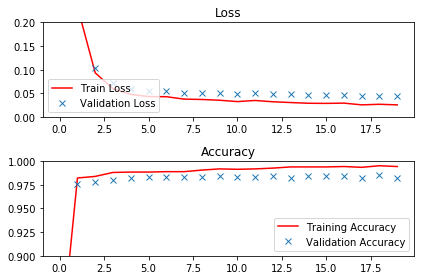

In [94]:
iter_ = len(train_acc_iter)
loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(range(iter_), train_loss_iter, 'r', label='Train Loss')
loss_plot.plot(range(iter_), val_loss_iter, 'x', label='Validation Loss')
loss_plot.legend(loc='lower left')
loss_plot.set_ylim([0, 0.2])

acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(range(iter_), train_acc_iter, 'r', label='Training Accuracy')
acc_plot.plot(range(iter_), val_acc_iter, 'x', label='Validation Accuracy')
acc_plot.legend(loc='lower right')
acc_plot.set_ylim([0.9,1.0])
plt.tight_layout()
plt.show()

### Check Point 2

### Test Model

In [81]:
import tensorflow as tf
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
import csv

In [82]:
with open('test_ids') as f:
    reader = csv.reader(f, delimiter='\n')
    test_ids = np.array([each for each in reader if len(each) > 0]).squeeze()
with open('test_codes') as f:
    test_codes = np.fromfile(f, dtype=np.float32)
    test_codes = test_codes.reshape((len(test_ids), -1))

In [83]:
def get_test_batches(x, n_batches=10):
    """ Return a generator that yields batches from arrays x and y. """
    batch_size = len(x)//n_batches
    
    for ii in range(0, n_batches*batch_size, batch_size):
        # If we're not on the last batch, grab data with size batch_size
        if ii != (n_batches-1)*batch_size:
            X = x[ii: ii+batch_size]
        # On the last batch, grab the rest of the data
        else:
            X = x[ii:]
        # I love generators
        yield X

In [84]:
loaded_graph = tf.Graph()
predictions = []
save_model_path = './dog_vs_cat'

with tf.Session(graph=loaded_graph) as sess:
    #Load model
    loader = tf.train.import_meta_graph(save_model_path + '.meta')
    loader.restore(sess, save_model_path)
        
    # Get Tensors from loaded model
    loaded_inputs = loaded_graph.get_tensor_by_name('inputs:0')
    loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
    loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
    
    for x in get_test_batches(test_codes):
        feed = {loaded_inputs: x,
                loaded_keep_prob: 1.0}
        test_predictions = sess.run(tf.nn.softmax(loaded_logits), feed_dict=feed)
        predictions.append(test_predictions[:,0])
    
    predictions = np.concatenate(predictions)

INFO:tensorflow:Restoring parameters from ./dog_vs_cat


In [85]:
submissions = {'id': test_ids,
               'label': predictions}
df = pd.DataFrame.from_dict(submissions)
df['id'] = pd.to_numeric(df['id'])
df = df.sort_values(by='id')
df.to_csv('submission.csv', index=False)